# Notebook Description
This notebook runs the experiment of using 2d-CNN on the audio spectograms rather than on the text themselved.

## Setup

In [ ]:
import os
import librosa
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings("ignore")

%load_ext google.colab.data_table
from google.colab import data_table
from google.colab import drive

# Set options and load files
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext google.colab.data_table
from google.colab import data_table
from google.colab import drive

drive.mount('/content/drive')
os.chdir("YOUR FOLDER HERE")
raw_data_folder = './data/raw/'
interim_data_folder = './data/interim/'
processed_data_folder = './data/processed/'
models_folder = './models/'

audio_folder = 'mixed_datasets_audio/'


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### utils

In [ ]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


## Load Data

In [ ]:
# load
train_df_shuffled = pd.read_csv(interim_data_folder + 'train_df_shuffled.csv', index_col=0)
validation_df_shuffled = pd.read_csv(interim_data_folder + 'validation_df_shuffled.csv', index_col=0)
test_df_shuffled = pd.read_csv(interim_data_folder + 'test_df_shuffled.csv', index_col=0)

y_train=train_df_shuffled['y'].values
y_validation=validation_df_shuffled['y'].values
y_test=test_df_shuffled['y'].values

y_train = tf.cast(y_train, tf.float32)
y_validation = tf.cast(y_validation, tf.float32)
y_test = tf.cast(y_test, tf.float32)



In [ ]:
train_names_mat = np.load(processed_data_folder + 'train_names_mat.npy',allow_pickle='True')
train_nicknames_mat = np.load(processed_data_folder + 'train_nicknames_mat.npy',allow_pickle='True')
validation_names_mat = np.load(processed_data_folder + 'validation_names_mat.npy',allow_pickle='True')
validation_nicknames_mat = np.load(processed_data_folder + 'validation_nicknames_mat.npy',allow_pickle='True')
test_names_mat = np.load(processed_data_folder + 'test_names_mat.npy',allow_pickle='True')
test_nicknames_mat = np.load(processed_data_folder + 'test_nicknames_mat.npy',allow_pickle='True')


train_names_mat = tf.expand_dims(train_names_mat, axis = -1)
train_nicknames_mat = tf.expand_dims(train_nicknames_mat, axis = -1)
validation_names_mat = tf.expand_dims(validation_names_mat, axis = -1)
validation_nicknames_mat = tf.expand_dims(validation_nicknames_mat, axis = -1)
test_names_mat = tf.expand_dims(test_names_mat, axis = -1)
test_nicknames_mat = tf.expand_dims(test_nicknames_mat, axis = -1)


print(train_names_mat.shape)
print(train_nicknames_mat.shape)
print(validation_names_mat.shape)
print(validation_nicknames_mat.shape)
print(test_names_mat.shape)
print(test_nicknames_mat.shape)


(7540, 128, 80, 1)
(7540, 128, 80, 1)
(1430, 128, 80, 1)
(1430, 128, 80, 1)
(1010, 128, 80, 1)
(1010, 128, 80, 1)


# <12K params

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_6 (InputLayer)           [(None, 128, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 model_2 (Functional)           (None, 1)            11689       ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

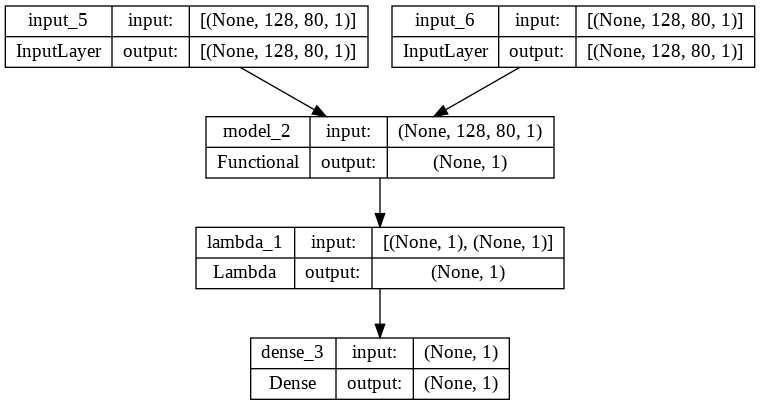

In [ ]:
input = layers.Input((128, 80, 1))
x = layers.Conv2D(16, (3, 3), activation="relu",padding='same')(input)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv2D(16, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = x + input

x = layers.Conv2D(16, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv2D(16, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = x + input

x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(8, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv2D(8, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(8, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv2D(8, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(4, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv2D(4, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(1)(x)

embedding_network = keras.Model(input, x)


input_1 = layers.Input((128, 80, 1))
input_2 = layers.Input((128, 80, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge = layers.Lambda(euclidean_distance)([tower_1, tower_2])
# normal = tf.keras.layers.BatchNormalization()(merge)
output_layer = layers.Dense(1, activation="sigmoid")(merge)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

opt = keras.optimizers.Adam(learning_rate=0.05)
margin = 0.5
siamese.compile(loss=loss(margin=margin), optimizer=opt)


print(siamese.summary())
tf.keras.utils.plot_model(siamese, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.optimizers import Adam


# checkpointer
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=75, mode='min'),
      ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=20, min_lr=0.001),
      ModelCheckpoint(filepath=models_folder + 'mixed_val_loss_shared_weights_2dCNN_15k.hdf5', 
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True, 
                      mode='min',
                      restore_best_weights=True)
]

# Train model on dataset
hist = siamese.fit(x = [train_names_mat, train_nicknames_mat],
                     y = y_train,
                       validation_data=([validation_names_mat, validation_nicknames_mat], 
                                        y_validation),
                       epochs = 100,
                       verbose = 1,
                       shuffle = True,
                       batch_size = 16,
                       callbacks=[keras_callbacks])


Epoch 1/100
470/472 [============================>.] - ETA: 0s - loss: 0.0437
Epoch 1: val_loss improved from inf to 0.03965, saving model to ./models/mixed_val_loss_shared_weights_2dCNN_15k.hdf5
472/472 [==============================] - 11s 17ms/step - loss: 0.0437 - val_loss: 0.0396 - lr: 0.0500
Epoch 2/100
471/472 [============================>.] - ETA: 0s - loss: 0.0387
Epoch 2: val_loss improved from 0.03965 to 0.03895, saving model to ./models/mixed_val_loss_shared_weights_2dCNN_15k.hdf5
472/472 [==============================] - 7s 14ms/step - loss: 0.0387 - val_loss: 0.0389 - lr: 0.0500
Epoch 3/100
472/472 [==============================] - ETA: 0s - loss: 0.0388
Epoch 3: val_loss improved from 0.03895 to 0.03775, saving model to ./models/mixed_val_loss_shared_weights_2dCNN_15k.hdf5
472/472 [==============================] - 7s 14ms/step - loss: 0.0388 - val_loss: 0.0377 - lr: 0.0500
Epoch 4/100
468/472 [============================>.] - ETA: 0s - loss: 0.0389
Epoch 4: val_los

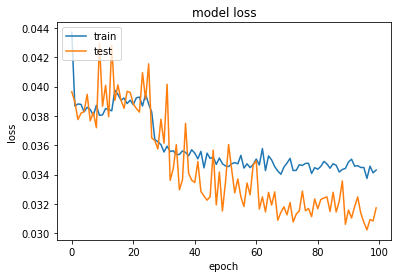

In [ ]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

236/236 [==============================] - 2s 5ms/step
0.8317572636478129


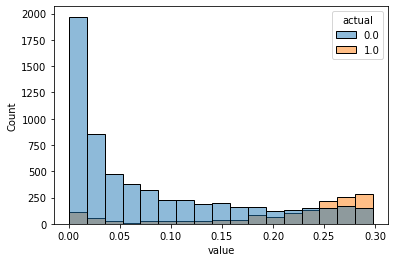

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_shared_weights_2dCNN_15k.hdf5', custom_objects={'contrastive_loss': loss})

preds_train = pd.DataFrame(model.predict([train_names_mat, train_nicknames_mat]), columns = ['value'])
preds_train['actual'] = y_train

fpr, tpr, thresholds = metrics.roc_curve(preds_train['actual'].values, 
                                         preds_train['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_train)

45/45 [==============================] - 1s 6ms/step
0.8131678199422955


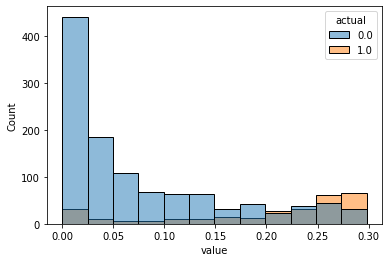

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_shared_weights_2dCNN_15k.hdf5', custom_objects={'contrastive_loss': loss})

preds_validation = pd.DataFrame(model.predict([validation_names_mat, validation_nicknames_mat]), columns = ['value'])
preds_validation['actual'] = y_validation

fpr, tpr, thresholds = metrics.roc_curve(preds_validation['actual'].values, 
                                         preds_validation['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_validation)

# 30K params

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_9 (InputLayer)           [(None, 128, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 model_4 (Functional)           (None, 1)            34041       ['input_8[0][0]',                
                                                                  'input_9[0][0]']          

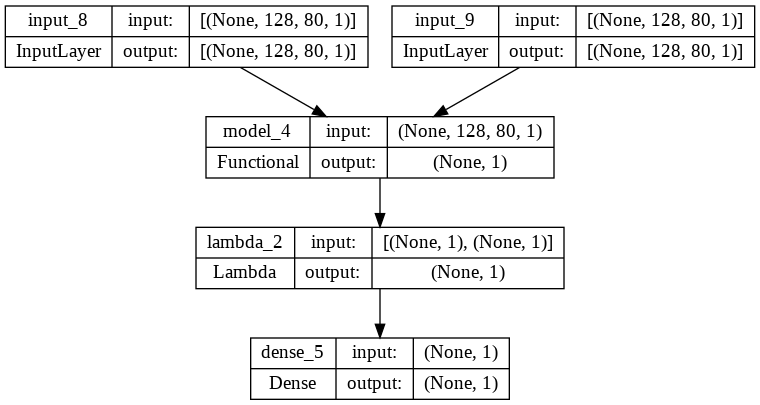

In [ ]:

input = layers.Input((128, 80, 1))
x = layers.Conv2D(32, (3, 3), activation="relu",padding='same')(input)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = x + input

x = layers.Conv2D(32, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = x + input

x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(8, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv2D(8, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(8, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv2D(8, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(4, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Conv2D(4, (3, 3), activation="relu",padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = layers.AveragePooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(1)(x)

embedding_network = keras.Model(input, x)


input_1 = layers.Input((128, 80, 1))
input_2 = layers.Input((128, 80, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge = layers.Lambda(euclidean_distance)([tower_1, tower_2])
# normal = tf.keras.layers.BatchNormalization()(merge)
output_layer = layers.Dense(1, activation="sigmoid")(merge)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

opt = keras.optimizers.Adam(learning_rate=0.05)
margin = 0.5
siamese.compile(loss=loss(margin=margin), optimizer=opt)


print(siamese.summary())
tf.keras.utils.plot_model(siamese, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.optimizers import Adam


# checkpointer
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=75, mode='min'),
      ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=20, min_lr=0.001),
      ModelCheckpoint(filepath=models_folder + 'mixed_val_loss_shared_weights_2dCNN_30k.hdf5', 
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True, 
                      mode='min',
                      restore_best_weights=True)
]

# Train model on dataset
hist = siamese.fit(x = [train_names_mat, train_nicknames_mat],
                     y = y_train,
                       validation_data=([validation_names_mat, validation_nicknames_mat], 
                                        y_validation),
                       epochs = 100,
                       verbose = 1,
                       shuffle = True,
                       batch_size = 16,
                       callbacks=[keras_callbacks])

# training_generator = DataGenerator(dataset = 'train', batch_size=16)
# validation_generator = DataGenerator(dataset = 'validation', batch_size=16)

# hist = siamese.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     use_multiprocessing=True,
#                     workers=6,
#                     verbose = 1,
#                     callbacks=[keras_callbacks])-

Epoch 1/100
472/472 [==============================] - ETA: 0s - loss: 0.0462
Epoch 1: val_loss improved from inf to 0.03969, saving model to ./models/mixed_val_loss_shared_weights_2dCNN_30k.hdf5
472/472 [==============================] - 11s 18ms/step - loss: 0.0462 - val_loss: 0.0397 - lr: 0.0500
Epoch 2/100
471/472 [============================>.] - ETA: 0s - loss: 0.0393
Epoch 2: val_loss improved from 0.03969 to 0.03873, saving model to ./models/mixed_val_loss_shared_weights_2dCNN_30k.hdf5
472/472 [==============================] - 8s 16ms/step - loss: 0.0392 - val_loss: 0.0387 - lr: 0.0500
Epoch 3/100
471/472 [============================>.] - ETA: 0s - loss: 0.0392
Epoch 3: val_loss improved from 0.03873 to 0.03814, saving model to ./models/mixed_val_loss_shared_weights_2dCNN_30k.hdf5
472/472 [==============================] - 8s 16ms/step - loss: 0.0392 - val_loss: 0.0381 - lr: 0.0500
Epoch 4/100
472/472 [==============================] - ETA: 0s - loss: 0.0387
Epoch 4: val_los

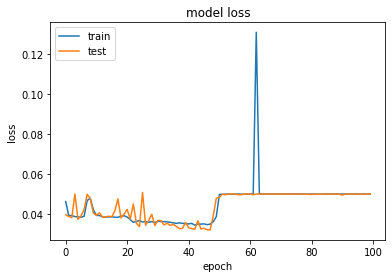

In [ ]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

236/236 [==============================] - 2s 6ms/step
0.8159456484074327


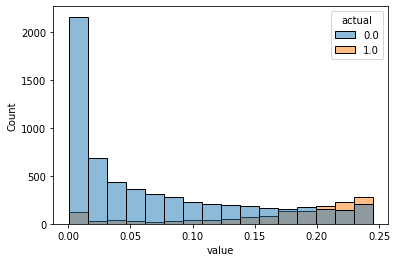

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_shared_weights_2dCNN_30k.hdf5', custom_objects={'contrastive_loss': loss})

preds_train = pd.DataFrame(model.predict([train_names_mat, train_nicknames_mat]), columns = ['value'])
preds_train['actual'] = y_train

fpr, tpr, thresholds = metrics.roc_curve(preds_train['actual'].values, 
                                         preds_train['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_train)

45/45 [==============================] - 1s 6ms/step
0.7951259841557043


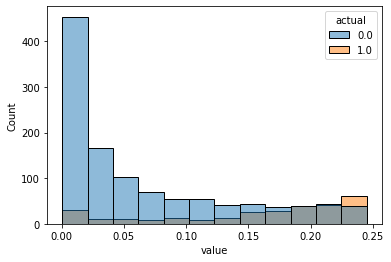

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_shared_weights_2dCNN_30k.hdf5', custom_objects={'contrastive_loss': loss})

preds_validation = pd.DataFrame(model.predict([validation_names_mat, validation_nicknames_mat]), columns = ['value'])
preds_validation['actual'] = y_validation

fpr, tpr, thresholds = metrics.roc_curve(preds_validation['actual'].values, 
                                         preds_validation['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_validation)